# Предсказание успешности прохождения пользователями он-лайн курса на stepik 

## Описание проекта

Необходимо построить модель, которая бы предсказывала по активности нового пользователя в первые 2 дня обучения на онлайн курсе ["Введение в анализ данных в R"](https://stepik.org/course/129/promo), пройдёт ли он этот курс в итоге или нет. Считается, что пользователь прошёл курс, если успешно решил 40 и более практических задач.

В качестве данных нам предоставлены логи пользователей за 3 года - с 15 июня 2015 по 19 апреля 2018 года. Проверяться модель будет на данных об активности в первые 2 дня обучения пользователей, пришедших на курс в период с мая 2018 по январь 2019. Качество прогноза модели оценивается по значению ROC AUC.

Задача взята из курса ["Введение в Data Science и машинное обучение"](https://stepik.org/course/4852/). Там же есь таблица лучших результатов студентов, принявших участие в решении задачи.

## <a name="0"> Структура проекта </a>

- [Загрузка данных и ознакомление с ними](#1)
  - [Таблица events_train](#1.1)
  - [Таблица submissions_train](#1.2)
- [Подготовка данных для обучения модели](#2)
- [Генерация новых признаков](#3)
- [Обучение модели](#4)
- [Тестирование модели](#5)
- [Выводы](#6)

## <a name="1"> Загрузка данных и ознакомление с ними </a>

Загрузим библиотеки для работы с таблицами, временными данными, визуализации и машинного обучения:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter('ignore')

### <a name="1.1"> Таблица events_train </a>

Загрузим таблицу и посмотрим на неё:

In [2]:
events_train = pd.read_csv('/Users/polzovatel/Desktop/Projects/Stepik_ml_contest/event_data_train.csv')

In [3]:
events_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


В таблице events_train хранятся данные о действиях, которые совершают студенты со стэпами:
- step_id - id стэпа;
- user_id - анонимизированный id юзера;
- timestamp - время наступления события в формате unix date (то есть количество секунд, прошедшее с 1970-01-01 00:00:00);
- action - событие, возможные значения: 
  - discovered - пользователь впервые перешёл на стэп;
  - viewed - просмотр стэпа (может происходить многократно для одного стэпа);
  - started_attempt - начало попытки решить шаг (ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага);
  - passed - удачное решение практического шага или квиза.

In [4]:
len(events_train), events_train['user_id'].nunique(), events_train['step_id'].nunique()

(3480703, 19234, 198)

В таблице 3 480 703 действия, совершённых 19 234 уникальными пользователями со 198 стэпами.

Проверим интервал времени, за который нам предоставлены данные. Для этого сначала переведём формат времени из timestamp в datetime:

In [5]:
events_train['datetime'] = pd.to_datetime(events_train['timestamp'], unit='s')
events_train['datetime'].min(), events_train['datetime'].max()

(Timestamp('2015-06-15 04:00:48'), Timestamp('2018-05-19 23:33:31'))

Действительно, данные собраны примерно за 3 года - с 15 июня 2015 по 19 апреля 2018 года.

Посчитаем количество встречающихся событий:

In [6]:
events_train['action'].value_counts()

viewed             1830830
discovered          689495
passed              650331
started_attempt     310047
Name: action, dtype: int64

Чаще всего стэпы просматривают, реже всего - начинают решать практическое задание. 

Посмотрим, как активность пользователей менялась во времени. В качестве единицы измерения времени возьмём 1 месяц. Если брать меньший интервал, например, день, то график превратится в пилу, которую сложнее визуально воспринимать. 

Добавим столбец с месяцами, сгруппируем по месяцам и просуммируем активности, затем выведем графики:

In [7]:
events_train['month'] = events_train['datetime'].astype('datetime64[M]')
events_train_by_date = events_train.pivot_table(index='month', columns='action', values='step_id', aggfunc='count')

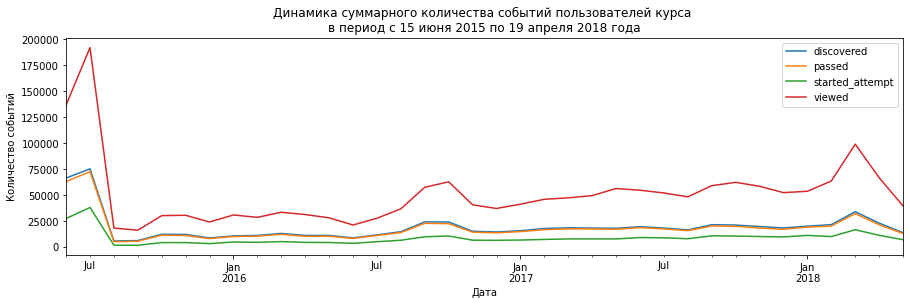

In [8]:
ax = events_train_by_date.plot(y='discovered', label='discovered', figsize=(15, 4))
events_train_by_date.plot(y='passed', label='passed', ax=ax)
events_train_by_date.plot(y='started_attempt', label='started_attempt', ax=ax)
events_train_by_date.plot(y='viewed', label='viewed', ax=ax)
plt.title("Динамика суммарного количества событий пользователей курса \nв период с 15 июня 2015 по 19 апреля 2018 года") 
plt.xlabel("Дата")
plt.ylabel("Количество событий") 
plt.show()

Большое количество событий происходило в самом начале. Видимо, тогда курс был только запущен и было много желающих его пройти. Затем первая волна схлынула и далее на протяжении почти 3 лет количество событий постепенно росло. Скорее всего это связано с набирающим популярность он-лайн образованием и непосредственно площадкой stepik.

Была идея построить воронку переходов пользователей от стэпа к стэпу, чтобы посмотреть где они чаще всего "отваливаются". Однако id стэпов идут не по порядку. 

Если расположить стэпы в порядке убывания количества открывших их пользователей, то это не будет отражать их реальную последовательность в курсе: пользователи могут просто не открывать какие-то стэпы, потому что в них нельзя получить баллы, либо могут двигаться путанной дорогой в освоении курса - например, возвращаться к стэпам с важной инфомацией. Если проследить последовательности открытия стэпов у нескольких пользователей, то они не совпадают, что подтверждает предположение, что пользователи движутся по курсу "своими" дорогами. Таким образом, такая сортировка не восстановит правильный порядок следования стэпов. 

[В начало](#0)

### <a name="1.2"> Таблица submissions_train </a>

Загрузим таблицу и посмотрим на неё:

In [9]:
submissions_train = pd.read_csv('/Users/polzovatel/Desktop/Projects/Stepik_ml_contest/submissions_data_train.csv')

In [10]:
submissions_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


В таблице submissions_train хранятся данные о времени и статусах сабмитов к практическим заданиям:
- step_id - id стэпа;
- timestamp - время отправки решения в формате unix date;
- user_id - анонимизированный id юзера;
- submission_status - статус решения, возможные значения:
  - correct - задание решено верно;
  - wrong - задание решено неверно.

In [11]:
len(submissions_train), submissions_train['user_id'].nunique(), submissions_train['step_id'].nunique()

(509104, 9940, 76)

В таблице 509 104 сабмита, совершённых 9940 уникальными пользователями в 76 стэпах.

Проверим интервал времени, за который нам предоставлены данные.

In [12]:
submissions_train['datetime'] = pd.to_datetime(submissions_train['timestamp'], unit='s')
submissions_train['datetime'].min(), submissions_train['datetime'].max()

(Timestamp('2015-06-15 04:02:24'), Timestamp('2018-05-19 23:07:07'))

Интервал времени соответствует данным из таблицы submissions_train: данные собраны с 15 июня 2015 по 19 апреля 2018 года.

Посчитаем количество встречающихся сабмитов:

In [13]:
submissions_train['submission_status'].value_counts()

wrong      286399
correct    222705
Name: submission_status, dtype: int64

Неправильных ответов немного больше. Почти каждая вторая попытка ответа оказывалась верной.

Посмотрим, как количество сабмитов менялось во времени. Добавим столбец с месяцами, сгруппируем по месяцам и просуммируем сабмиты, затем выведем графики:

In [14]:
submissions_train['month'] = submissions_train['datetime'].astype('datetime64[M]')
submissions_train_by_date = submissions_train.pivot_table(index='month', columns='submission_status'
                                                                      , values='step_id', aggfunc='count')

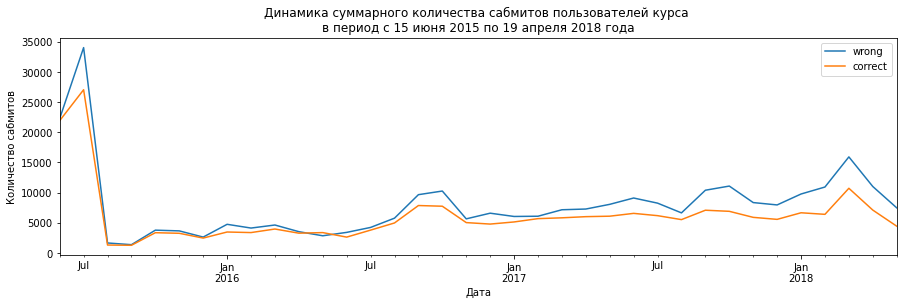

In [15]:
ax = submissions_train_by_date.plot(y='wrong', label='wrong', figsize=(15, 4))
submissions_train_by_date.plot(y='correct', label='correct', ax=ax)
plt.title("Динамика суммарного количества сабмитов пользователей курса \nв период с 15 июня 2015 по 19 апреля 2018 года") 
plt.xlabel("Дата")
plt.ylabel("Количество сабмитов") 
plt.show()

В целом график похож на график событий пользователей, что разумно. Можно отметить, что к концу рассматриваемого периода графики правильных и неправильных сабмитов начали расходиться, то есть пользователи стали чаще делать неправильные сабмиты.

Проверим, что все пользователи, совершавшие сабмиты, есть среди пользователей с событиями. Для этого из множества пользователей из таблицы events_train вычтем множество пользователей из таблицы submissions_train и проверим, что количество оставшихся пользователей равняется  разности количества пользователей в каждой из таблиц. Равенство не будет выполнятся, если в таблице submissions_train будут пользователи, которых нет в events_train:

In [16]:
len(set(events_train['user_id']) - set(submissions_train['user_id'])) == \
events_train['user_id'].nunique() - submissions_train['user_id'].nunique()

True

"Неожиданных" пользователей в таблице submissions_train нет.

Сделаем такую же проверку для стэпов:

In [17]:
len(set(events_train['step_id']) - set(submissions_train['step_id'])) == \
events_train['step_id'].nunique() - submissions_train['step_id'].nunique()

True

"Неожиданных" стэпов в таблице submissions_train также нет.

[В начало](#0)

## <a name="2"> Подготовка данных для обучения модели </a>

Чтобы данные подходили для обучения модели, необходимо выполнить следующие шаги:
1. выявить всех пользователей, которые прошли курс (набрали 40 и более правильных сабмитов) - так мы сформируем вектор целевой переменной y_train;
2. ограничить информацию об активности каждого пользователя только 2 днями, начиная с его первой активности;
3. сгруппировать данные по пользователям и рассчитать необходимые признаки для обучения модели - так мы сформируем матрицу признаков X_train.

Составим список пользователей, которые прошли курс:

In [18]:
submissions_train_by_user = submissions_train.pivot_table(index='user_id', columns='submission_status'
                              , values='step_id', aggfunc='count').fillna(0)
finished_users = submissions_train_by_user.query('correct >= 40')
finished_users['finished'] = 1
del finished_users['correct']
del finished_users['wrong']

In [19]:
finished_users.head()

submission_status,finished
user_id,
16,1
22,1
30,1
34,1
39,1


In [20]:
len(finished_users), len(finished_users) / events_train['user_id'].nunique()

(2013, 0.10465841738587917)

Из 19 234 пользователей 2013 прошли курс. Это примерно 10%, что является типичной конверсией для онлайн курсов.

Теперь соберём таблицу признаков для каждого пользователя за 2 суток со старта обучения. Сначала для каждого пользователя найдём дату первого события, то есть момент, когда пользователь начал проходить курс, а также момент спустя 2 суток:

In [21]:
thresholds = pd.DataFrame(events_train.groupby('user_id')['timestamp'].min())
thresholds.columns = ['first_ts']
thresholds['threshold'] = thresholds['first_ts'] + 2 * 24 * 60 * 60

In [22]:
thresholds.head()

,first_ts,threshold
user_id,,
1,1472827464,1473000264
2,1514383364,1514556164
3,1434358476,1434531276
5,1466156809,1466329609
7,1521634660,1521807460


Объединим таблицы events_train и thresholds по id пользователя. Затем отберём все события, которые случились до истечения 2 суток с начала прохождения курса:

In [23]:
new_events_train = events_train.merge(thresholds, on='user_id', how='left')
new_events_train['below_threshold'] = new_events_train['threshold'] - new_events_train['timestamp'] > 0
new_events_train = new_events_train.query('below_threshold')

In [24]:
new_events_train.head()

,step_id,timestamp,action,user_id,datetime,month,first_ts,threshold,below_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-01,1434340848,1434513648,True
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-01,1434340848,1434513648,True
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-01,1434340848,1434513648,True
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-01,1434340848,1434513648,True
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-01,1434340848,1434513648,True


Для каждого пользователя посчитаем количество событий в первые 2 дня:

In [25]:
events_by_user = new_events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count')\
.fillna(0)

In [26]:
events_by_user.head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1.0,0.0,0.0,1.0
2,9.0,9.0,2.0,9.0
3,15.0,15.0,4.0,20.0
5,1.0,1.0,0.0,1.0
7,1.0,1.0,0.0,1.0


Объединим таблицы submissions_train и thresholds по id пользователя. Затем отберём все сабмиты, которые случились до истечения 2 суток с начала прохождения курса:

In [27]:
new_submissions_train = submissions_train.merge(thresholds, on='user_id', how='left')
new_submissions_train['below_threshold'] = new_submissions_train['threshold'] \
- new_submissions_train['timestamp'] > 0
new_submissions_train = new_submissions_train.query('below_threshold')

In [28]:
new_submissions_train.head()

,step_id,timestamp,submission_status,user_id,datetime,month,first_ts,threshold,below_threshold
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-01,1434345977,1434518777,True
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-01,1434345977,1434518777,True
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-01,1434345977,1434518777,True
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-01,1434345977,1434518777,True
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-01,1434345977,1434518777,True


Для каждого пользователя посчитаем количество сабмитов в первые 2 дня:

In [29]:
submissions_by_user = new_submissions_train.pivot_table(index='user_id', columns='submission_status'
                                                        , values='step_id', aggfunc='count').fillna(0)
submissions_by_user.head()

submission_status,correct,wrong
user_id,,
2,2.0,0.0
3,4.0,4.0
8,9.0,21.0
14,0.0,1.0
16,18.0,23.0


In [30]:
len(submissions_by_user)

8815

Из 19 234 пользователей только 8815 делали сабмиты.

Объединим таблицы events_by_user, submissions_by_user и finished по пользователям:

In [31]:
train = events_by_user.merge(submissions_by_user, on='user_id', how='outer')\
.merge(finished_users, on='user_id', how='outer').fillna(0)
train.head()

,discovered,passed,started_attempt,viewed,correct,wrong,finished
user_id,,,,,,,
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9.0,9.0,2.0,9.0,2.0,0.0,0.0
3,15.0,15.0,4.0,20.0,4.0,4.0,0.0
5,1.0,1.0,0.0,1.0,0.0,0.0,0.0
7,1.0,1.0,0.0,1.0,0.0,0.0,0.0


Теперь для каждого пользователя у нас есть следующая информация:
- количество событий каждого типа в первые 2 дня;
- количество сабмитов каждого типа в первые 2 дня;
- информация о том, прошёл он курс или нет.

Сделаем проверку, что в процессе преобразования таблиц мы не потеряли информацию:

In [32]:
len(train), len(train.query('correct > 0 or wrong > 0')), len(train.query('finished == 1'))

(19234, 8815, 2013)

Цифры сходятся: 19 234 пользователя, из них 8815 делали сабмиты и 2013 завершили курс.

Проверим, нет ли пропусков:

In [33]:
train.isnull().sum()

discovered         0
passed             0
started_attempt    0
viewed             0
correct            0
wrong              0
finished           0
dtype: int64

Пропусков нет.

Изучим возможность обогатить таблицу признаков новыми данными.

[В начало](#0)

## <a name="3"> Генерация новых признаков </a>

Попробуем найти дополнительную информацию в имеющихся данных. Посмотрим, как меняется доля пользователей, завершивших курс, в зависимости от того, когда они начали его проходить:

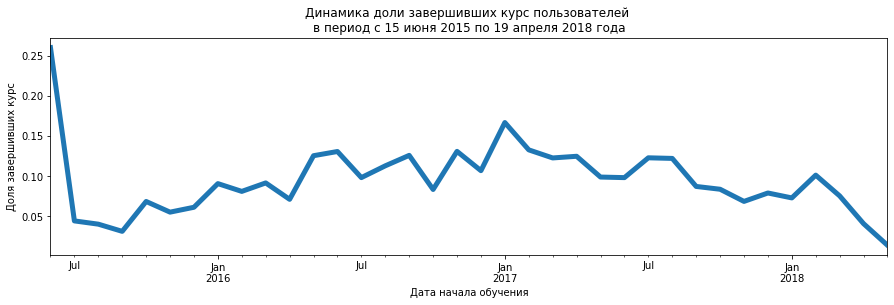

In [34]:
train = train.merge(thresholds, on='user_id')
train['month'] = pd.to_datetime(train['first_ts'], unit='s').astype('datetime64[M]')
pd.DataFrame(train.groupby('month')['finished'].mean())\
.plot(y='finished', figsize=(15, 4), linewidth=5, legend=False)
plt.title("Динамика доли завершивших курс пользователей \nв период с 15 июня 2015 по 19 апреля 2018 года") 
plt.xlabel("Дата начала обучения")
plt.ylabel("Доля завершивших курс") 
plt.show()

В первый месяц с открытия курса (июнь 2015 года) пришли пользователи, по которым была высокая доля завершивших курс - около 25%. Возможно это связано с тем, что многие из них были мотивированы и ожидали запуска курса. Затем доля завершивших курс опустилась и колебалась в диапазоне примерно 5-15%. Скорее всего начали приходить уже менее мотивированные пользователи. 

Первый месяц можно считать аномальным. Поэтому можно предположить, что если обучать модель на данных без информации за этот месяц, то модель не переобучится и покажет лучше результат на тестовых данных. Однако экспериментально установлено, что исключение данных за июнь 2015 года только ухудшает прогноз модели. 

Посмотрим, как меняется доля пользователей, завершивших курс, в зависимости от того, в какой месяц они начали его проходить:

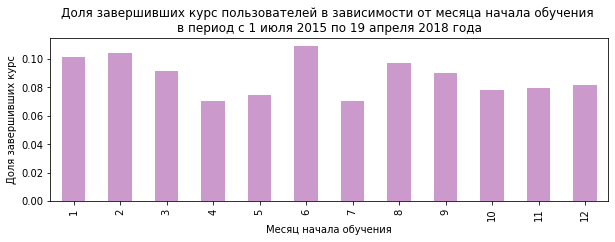

In [35]:
train['month_num'] = train['month'].dt.month
# исключим аномальный первый месяц курса (июнь 2015):
pd.DataFrame(train.query('month > "2015-06-01"').groupby('month_num')['finished'].mean())\
.plot(y='finished', kind='bar', figsize=(10, 3), legend=False, color='purple', alpha=.4)
plt.title("Доля завершивших курс пользователей в зависимости от месяца \
начала обучения \nв период с 1 июля 2015 по 19 апреля 2018 года") 
plt.xlabel("Месяц начала обучения")
plt.ylabel("Доля завершивших курс") 
plt.show()

Доля завершивших курс меняется от месяца к месяцу. Например, в июне доля примерно на треть больше, чем в марте, апреле и июле. Можно предположить, что добавление в данных вероятности прохождения курса в зависимости от месяца улучшит качество модели. Однако экспериментально установлено, что добавление такого признака не улучшает прогноз модели. 

Посмотрим, как меняется доля пользователей, завершивших курс, в зависимости от того, в какой день недели они начали его проходить:

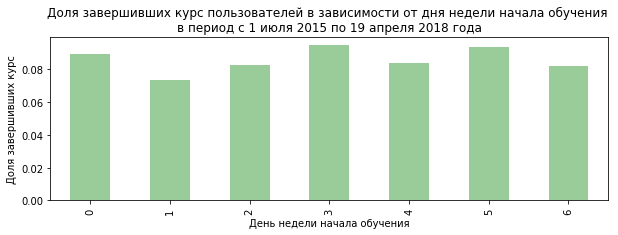

In [36]:
train['weekday'] = train['month'].dt.weekday
# исключим аномальный первый месяц курса (июнь 2015):
pd.DataFrame(train.query('month > "2015-06-01"').groupby('weekday')['finished'].mean())\
.plot(y='finished', kind='bar', figsize=(10, 3), legend=False, color='green', alpha=.4)
plt.title("Доля завершивших курс пользователей в зависимости от дня недели \
начала обучения \nв период с 1 июля 2015 по 19 апреля 2018 года") 
plt.xlabel("День недели начала обучения")
plt.ylabel("Доля завершивших курс") 
plt.show()

Доля завершивших курс немного плавает в зависимости от дня недели старта обучения. Можно предположить, что добавление в данных вероятности прохождения курса в зависимости от дня недели улучшит качество модели. Однако экспериментально установлено, что и с этими данными прогноз модели не улучшается. 

Удалим все неоправдавшие себя признаки:

In [37]:
del train['month']
del train['month_num']
del train['weekday']
del train['threshold'] # был добавлен опосредованно при определении месяца начала обучения пользователей

Также было проверно, что качество прогноза модели не улучшается при добавлении типа дня начала прохождения курса (выходной или будний). Однако улучшают прогноз такие признаки:
- время наступления первого события в формате unix date;
- суммарное количество событий всех типов;
- суммарное количество сабмитов всех типов.

Добавим их в таблицу train.

In [38]:
# время наступления первого события уже было опосредованно добавлено в таблицу train
train['ev_sum'] = train['discovered'] + train['passed'] + train['started_attempt'] + train['viewed']
train['sub_sum'] = train['correct'] + train['wrong']

Проверим, что столбцы добавились в таблицу:

In [39]:
train.head()

,discovered,passed,started_attempt,viewed,correct,wrong,finished,first_ts,ev_sum,sub_sum
user_id,,,,,,,,,,
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1472827464,2.0,0.0
2,9.0,9.0,2.0,9.0,2.0,0.0,0.0,1514383364,29.0,2.0
3,15.0,15.0,4.0,20.0,4.0,4.0,0.0,1434358476,54.0,8.0
5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1466156809,3.0,0.0
7,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1521634660,3.0,0.0


Создадим матрицу признаков пользователей и вектор целевой переменной:

In [40]:
X_train = train.drop(['finished'], axis = 1)
y_train = train['finished']

Теперь данные готовы для обучения модели.

[В начало](#0)

## <a name="4"> Обучение модели </a>

Для построения прогноза, пройдёт пользователь курс или нет, проверим следующие алгоритмы, подходящие для задачи бинарной классификации:
- логистическая регрессия (Logistic Regression);
- метод опорных векторов (Support Vector Machines);
- наивный байесовский метод (Naive Bayes);
- линейный дискриминантный анализ (Linear Discriminant Analysis);
- дерево решений (Decision Tree Classifier);
- случайный лес (Random Forest Classifier);
- градиентный бустинг (Gradient Boosting Classifier).

Оценим точность прогноза всех алгоритмов с параметрами по умолчанию из библиотеки sklearn. Оценивать будем на кросс-валидации с 5 группами (фолдами):

In [41]:
models = {'LogisticRegression': LogisticRegression()
         , 'SVC': SVC()
         , 'GaussianNB': GaussianNB()
         , 'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis()
         , 'DecisionTreeClassifier': DecisionTreeClassifier()
         , 'RandomForestClassifier': RandomForestClassifier()
         , 'GradientBoostingClassifier': GradientBoostingClassifier()}

In [42]:
models_scores = pd.DataFrame()
for model in models:
    cv_roc_auc_mean = cross_val_score(models[model], X_train, y_train, cv=5, scoring='roc_auc').mean()
    result_for_model = {'model': [model], 'cv_roc_auc_mean': [cv_roc_auc_mean]}
    models_scores = models_scores.append(pd.DataFrame(result_for_model))

Построим график:

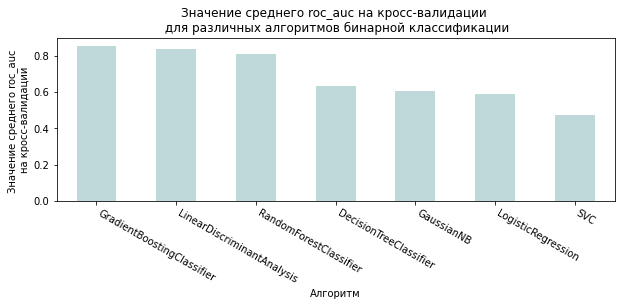

In [43]:
models_scores.sort_values('cv_roc_auc_mean', ascending=False)\
.plot(x='model', y='cv_roc_auc_mean', kind='bar', figsize=(10, 3), legend=False, color='cadetblue', alpha=.4)
plt.title("Значение среднего roc_auc на кросс-валидации \n для различных алгоритмов бинарной классификации") 
plt.xlabel("Алгоритм")
plt.ylabel("Значение среднего roc_auc \nна кросс-валидации") 
plt.xticks(rotation=-30, ha='left')
plt.show()

Наиболее точным оказался алгоритм градиентный бустинг. Подберём для него оптимальные параметры n_estimators и max_depth:

In [44]:
model = GradientBoostingClassifier()
param_grid = {'n_estimators': [20, 40, 60, 80], 'max_depth': [4, 5, 6]}
search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(X_train, y_train)
best_model = search.best_estimator_
best_model

GradientBoostingClassifier(max_depth=4, n_estimators=60)

Обучим модель с лучшими параметрами:

In [45]:
best_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=60)

Теперь у нас есть обученная модель, которую мы можем протестировать.

[В начало](#0)

## <a name="5"> Тестирование модели </a>

Загрузим тестовые данные:

In [46]:
events_test = pd.read_csv('/Users/polzovatel/Desktop/Projects/Stepik_ml_contest/events_data_test.csv')
submission_test = pd.read_csv('/Users/polzovatel/Desktop/Projects/Stepik_ml_contest/submission_data_test.csv')

Приведём их к признаковому описанию пользователей по аналогии с тренировочными данными:

In [47]:
events_by_user_test = events_test.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count')\
.fillna(0)
submission_by_user_test = submission_test.pivot_table(index='user_id', columns='submission_status', values='step_id'
                                                      , aggfunc='count').fillna(0)
X_test = events_by_user_test.merge(submission_by_user_test, on='user_id', how='outer').fillna(0)
first_ts_test = events_test.groupby('user_id')['timestamp'].min().reset_index()
first_ts_test.columns = ['user_id', 'first_ts']
X_test = X_test.merge(first_ts_test, on='user_id')
X_test['ev_sum'] = X_test['discovered'] + X_test['passed'] + X_test['started_attempt']+ X_test['viewed']
X_test['sub_sum'] = X_test['correct'] + X_test['wrong']
X_test = X_test.set_index('user_id')
X_test.head()

,discovered,passed,started_attempt,viewed,correct,wrong,first_ts,ev_sum,sub_sum
user_id,,,,,,,,,
4,1.0,1.0,0.0,1.0,0.0,0.0,1529331707,3.0,0.0
6,1.0,1.0,0.0,1.0,0.0,0.0,1546889407,3.0,0.0
10,2.0,2.0,0.0,6.0,0.0,0.0,1534585756,10.0,0.0
12,11.0,9.0,4.0,14.0,1.0,0.0,1537348474,38.0,1.0
13,70.0,70.0,35.0,105.0,29.0,36.0,1533034354,280.0,65.0


Матрица признаков X_test соответствует матрице X_train по форме записи. Теперь для каждого пользователя из матрицы X_test посчитаем уверенность модели в том, что он завершит курс. Затем выгрузим ответы в необходимом для проверки в тренажёре формате:

In [48]:
y_probas = best_model.predict_proba(X_test)
result = pd.DataFrame(y_probas[:, 1])
result['user_id'] = X_test.index
result.set_index('user_id', inplace=True)
result.columns = ['is_gone']
result.to_csv('/Users/polzovatel/Desktop/result.csv')
result.head()

,is_gone
user_id,
4,0.015290
6,0.015290
10,0.015813
12,0.017640
13,0.141740


Загружаем ответы в тренажёр и получаем результат тестирования модели. Значение ROC AUC составило:

![](http://dl4.joxi.net/drive/2021/05/11/0046/2540/3033580/80/f3028f65fc.jpg)

Экспериментально установлено, что лучший результат на тестовой выборке показывает модель с параметрами max_depth=4 и n_estimators=22:

In [49]:
best_model = GradientBoostingClassifier(max_depth=4, n_estimators=22)
best_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=22)

Для модели с такими параметрами значение ROC AUC на тестовых данных составило:

![](http://dl3.joxi.net/drive/2021/05/11/0046/2540/3033580/80/5d29f4494f.jpg)

Этот результат входит в 10-ку лучших результатов среди студентов, принявших участие в решении задачи:

![](http://dl3.joxi.net/drive/2021/05/10/0046/2540/3033580/80/353fcd19fe.jpg)

[В начало](#0)

## <a name="6"> Выводы </a>

На основе данных об активности пользователей на курсе "Введение в анализ данных в R" в период с 15 июня 2015 по 19 апреля 2018 года была построена модель прогнозирования успешности прохождения курса новыми пользователями. Модель позволяет оценить уверенность в том, пройдёт ли новый пользователь курс или нет, спустя 2 дня после того, как он начал проходить курс. В качестве оценки точности прогноза использовалось значение ROC AUC. Лучшим алгоритмом оказался градиентный бустинг, ROC AUC на тестовых данных составил 0,889. Результат входит в 10-ку лучших результатов среди студентов, принявших участие в решении задачи.

[В начало](#0)